In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/')
from FFT_get import fftget
from IFFT_get import ifftget
from Filterparameter import filter_get
from equivalent import CEL
from galacticnoise_get import gala
from Time_domain_Shower_Edata_get import time_data_get
from LNAparameter_get import LNA_get
sys.path.append(r'/Users/zhangkewen/Documents/scripts/scripts_for_OliviersIntern/')
import mod_fun
from scipy import signal
from scipy.fftpack import ifft,fft
from scipy.signal import hilbert
import iminuit
import scipy.optimize as opt
import scipy.interpolate as scipolate
import AiresInfoFunctions as Aires

In [2]:
e_theta, e_phi=77.0,45.0
f0=1
N=2000
Ts=0.5
[Lce_complex, antennas11_complex_short] = CEL(e_theta, e_phi, N, f0, 1, 0)

In [37]:
fmax=200
fmin=100
Lce_complex_short=np.zeros((fmax-fmin,3,3),dtype='complex')
for i in range(fmax-fmin):
    Lce_complex_short[i,:,:]=Lce_complex[i+fmin,:,:]


In [4]:
def spect(f,par):
    return par[0]*10**(par[1]*(f-200))


def minimi_spect(par,f,E):
    E_temp=spect(f,par)
    fmin=abs(abs(E_temp)-abs(E))
    chi2 = (fmin ** 2).sum()
    return chi2

method = "Nelder-Mead"
options = {'maxiter': 1000,'disp': True}

In [49]:
#fixed phase from arbitrary antenna

E_path='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_3.98_77.0_45.0_8/Stshp_MZS_QGS204JET_Proton_3.98_77.0_45.0_8/a4.trace'
[t_cut, ex_cut, ey_cut, ez_cut, fs, f0, f, f1, N] = time_data_get(E_path, Ts, 0)
E_angle = ex_cut
E_angle = np.column_stack((E_angle, ey_cut))
E_angle = np.column_stack((E_angle, ez_cut))
E_angle,_,_=fftget(E_angle,N,f1,0)

angle1=np.exp(1j*np.angle(E_angle[:,0]))[fmin:fmax]
angle2=np.exp(1j*np.angle(E_angle[:,1]))[fmin:fmax]
angle3=np.exp(1j*np.angle(E_angle[:,2]))[fmin:fmax]


Optimization terminated successfully.
         Current function value: 411891.013800
         Iterations: 87
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 769866.338507
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 727590.693723
         Iterations: 80
         Function evaluations: 154


[array([ 1.92850803e+04, -5.30167230e-04]),
 array([ 2.30672278e+04, -5.37962891e-04]),
 array([ 1.00688108e+04, -5.67667544e-04])]

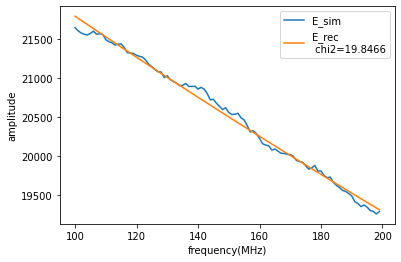

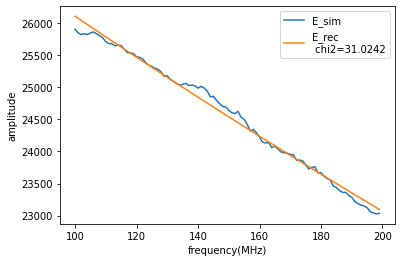

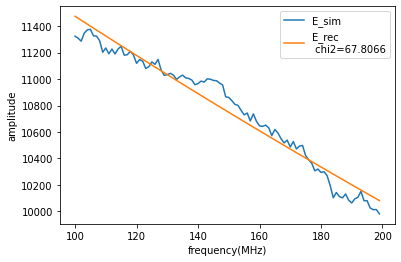

In [31]:
filedir='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/'
file_='Stshp_MZS_QGS204JET_Proton_3.98_77.0_45.0_8'
tracedir=filedir+file_+'/'+file_
sryfile=filedir+file_+'/'+file_+'.sry'
posfile=filedir+file_+'/antpos.dat'
zenith=Aires.GetZenithAngleFromSry(sryfile)*np.pi/180
azimuth=Aires.GetAzimuthAngleFromSry(sryfile)*np.pi/180
k_shower=np.array([np.sin(zenith)*np.cos(azimuth),np.sin(zenith)*np.sin(azimuth),np.cos(zenith)])
tracefile=tracedir+'/a40.trace'
[t_cut, ex_cut, ey_cut, ez_cut, fs, f0, f, f1, N] = time_data_get(tracefile, Ts, 0)
E=np.array([ex_cut,ey_cut,ez_cut])
E_fft,_,_=fftget(E.T,N,f1,0)
pars_fit=[]
f_cut=f[fmin:fmax]
E_cut=np.zeros((len(f_cut),3),dtype='complex')

for j in range(3):
    E_cut[:,j]=E_fft[fmin:fmax,j]
    #a1,b1,c1,_=spectE_fit(f_cut,E_cut[:,j],1e4,-1e-3,1e4)
    res_E=opt.minimize(minimi_spect, [1e3,-1e-2],args=(f_cut,E_cut[:,j]), method=method, options=options)['x']
    pars_fit.append(res_E)
    plt.figure()
    plt.plot(f_cut,abs(E_cut[:,j]),label='E_sim')
    resd=sum((abs(E_cut[:,j])-spect(f_cut,res_E))**2/abs(spect(f_cut,res_E)))
    plt.plot(f_cut,spect(f_cut,res_E),label='E_rec\n chi2='+str(round(resd,4)))
    plt.legend()
    plt.xlabel('frequency(MHz)')
    plt.ylabel('amplitude')
    
    
pars_fit


10609.044180385801 -0.00053016723 31633.385787737974 -0.000537962891 7266.351410884007 -0.000567667544 3219838.45153133
residual square of voltage from E_rec 3219838.4515313287
residual square of voltage from E_model 3941560.166086779


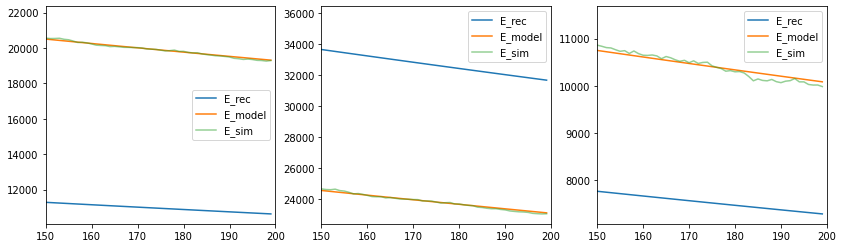

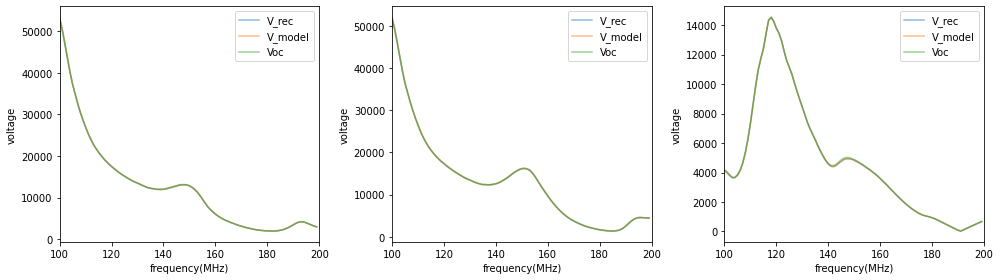

In [48]:
Voc_shower_complex = np.zeros((2000,3), dtype=complex)
for p in range(3):
    Voc_shower_complex[:, p] =Lce_complex[:, 0, p] * E_fft[:, 0] + Lce_complex[:, 1, p] * E_fft[:,1] + Lce_complex[:, 2,p] * E_fft[:,2] + 0



Lce_complex_short=np.zeros((fmax-fmin,3,3),dtype='complex')
for i in range(fmax-fmin):
    Lce_complex_short[i,:,:]=Lce_complex[i+fmin,:,:]

#here I use iminuit to fit
def amp_spec(a,b,f):
    return a*10**(b*(f-200))

class FF_amp1:
    def __init__(self,f,Vx,Vy,Vz):
        self.f=f
        self.Vx=Vx
        self.Vy=Vy
        self.Vz=Vz
    def chi2(self,a1,b1,a2,b2,a3,b3):
        Ex=amp_spec(a1,b1,self.f)*angle1
        Ey=amp_spec(a2,b2,self.f)*angle2
        Ez=amp_spec(a3,b3,self.f)*angle3
        Vx_temp= Lce_complex_short[:, 0, 0] * Ex  + Lce_complex_short[:, 1, 0] * Ey + Lce_complex_short[:, 2,0] * Ez + 0
        Vy_temp= Lce_complex_short[:, 0, 1] * Ex  + Lce_complex_short[:, 1, 1] * Ey + Lce_complex_short[:, 2,1] * Ez + 0
        Vz_temp= Lce_complex_short[:, 0, 2] * Ex  + Lce_complex_short[:, 1, 2] * Ey + Lce_complex_short[:, 2,2] * Ez + 0
        fmin=abs(abs(self.Vx)-abs(Vx_temp))+abs(abs(self.Vy)-abs(Vy_temp))+abs(abs(self.Vz)-abs(Vz_temp))
        chi2 = (fmin**2).sum()
        return chi2
    def __call__(self, a1,b1,a2,b2,a3,b3):
        chi2 = self.chi2(a1,b1,a2,b2,a3,b3)
        return chi2

    
def FF_amp1_fit(f,Vx,Vy,Vz,a1,b1,a2,b2,a3,b3):
    m = iminuit.Minuit(FF_amp1(f,Vx,Vy,Vz),a1,b1,a2,b2,a3,b3)
    Vxmax=max(abs((Voc_shower_complex[100:200,0])))
    Vymax=max(abs((Voc_shower_complex[100:200,1])))
    Vzmax=max(abs((Voc_shower_complex[100:200,2])))
    m.limits=([Vxmax/5,Vxmax*2],[-1e-2,-1e-7],[Vymax/5,Vymax*2],[-1e-2,-1e-7],[Vzmax/5,Vzmax*2],[-1e-2,-1e-7])
    #fixed slope
    m.fixed = (False,True,False,True,False,True)
    m.errordef = 1
    m.tol = 0.0001
    m.simplex()
    m.migrad()
    m.hesse()
    a1 = m.values["a1"]
    b1 = m.values["b1"]
    a2 = m.values["a2"]
    b2 = m.values["b2"]
    a3 = m.values["a3"]
    b3 = m.values["b3"]
    fval = m.fval
    print(a1,b1,a2,b2,a3,b3,fval)
    return a1,b1,a2,b2,a3,b3,fval

Vxf_cut=Voc_shower_complex[:,0][fmin:fmax]
Vyf_cut=Voc_shower_complex[:,1][fmin:fmax]
Vzf_cut=Voc_shower_complex[:,2][fmin:fmax]
V_cut=np.array([Vxf_cut,Vyf_cut,Vzf_cut]).T
a1,b1,a2,b2,a3,b3,min2=FF_amp1_fit(f_cut,Vxf_cut,Vyf_cut,Vzf_cut,1e3,-5.30167230e-04,2e+03, -5.37962891e-04,7e+02, -5.67667544e-04)


#electric field using parmeters fited above
Ex_model=spect(f_cut,pars_fit[0])*angle1
Ey_model=spect(f_cut,pars_fit[1])*angle2
Ez_model=spect(f_cut,pars_fit[2])*angle3
E_model=np.array([Ex_model,Ey_model,Ez_model]).T

#electric filed fitted from voltage
Ex_rec=amp_spec(a1,b1,f_cut)*angle1
Ey_rec=amp_spec(a2,b2,f_cut)*angle2
Ez_rec=amp_spec(a3,b3,f_cut)*angle3
E_rec=np.array([Ex_rec,Ey_rec,Ez_rec]).T

plt.figure(figsize=(14,4))
for i in range(3):
    plt.subplot(1,3,1+i)
    plt.plot(f_cut,abs(E_rec[:,i]),label='E_rec')
    plt.plot(f_cut,abs(E_model[:,i]),label='E_model')
    plt.plot(f_cut,abs(E_cut[:,i]),label='E_sim',alpha=0.5)
    plt.xlim([150,200])
    plt.legend()

Vx_rec= Lce_complex_short[:, 0, 0] * Ex_rec  + Lce_complex_short[:, 1, 0] * Ey_rec + Lce_complex_short[:, 2,0] * Ez_rec + 0
Vy_rec= Lce_complex_short[:, 0, 1] * Ex_rec  + Lce_complex_short[:, 1, 1] * Ey_rec + Lce_complex_short[:, 2,1] * Ez_rec + 0
Vz_rec= Lce_complex_short[:, 0, 2] * Ex_rec  + Lce_complex_short[:, 1, 2] * Ey_rec + Lce_complex_short[:, 2,2] * Ez_rec + 0

Vx_cut= Lce_complex_short[:, 0, 0] * E_cut[:,0]  + Lce_complex_short[:, 1, 0] * E_cut[:,1] + Lce_complex_short[:, 2,0] * E_cut[:,2] + 0
Vy_cut= Lce_complex_short[:, 0, 1] * E_cut[:,0]  + Lce_complex_short[:, 1, 1] * E_cut[:,1] + Lce_complex_short[:, 2,1] * E_cut[:,2] + 0
Vz_cut= Lce_complex_short[:, 0, 2] * E_cut[:,0]  + Lce_complex_short[:, 1, 2] * E_cut[:,1] + Lce_complex_short[:, 2,2] * E_cut[:,2] + 0

Vx_model= Lce_complex_short[:, 0, 0] * Ex_model  + Lce_complex_short[:, 1, 0] * Ey_model + Lce_complex_short[:, 2,0] * Ez_model + 0
Vy_model= Lce_complex_short[:, 0, 1] * Ex_model  + Lce_complex_short[:, 1, 1] * Ey_model + Lce_complex_short[:, 2,1] * Ez_model + 0
Vz_model= Lce_complex_short[:, 0, 2] * Ex_model  + Lce_complex_short[:, 1, 2] * Ey_model + Lce_complex_short[:, 2,2] * Ez_model + 0

resd=abs(abs(Vxf_cut)-abs(Vx_rec))+abs(abs(Vyf_cut)-abs(Vy_rec))+abs(abs(Vzf_cut)-abs(Vz_rec))
print('residual square of voltage from E_rec',sum(resd**2))
resd=abs(abs(Vxf_cut)-abs(Vx_model))+abs(abs(Vyf_cut)-abs(Vy_model))+abs(abs(Vzf_cut)-abs(Vz_model))
print('residual square of voltage from E_model',sum(resd**2))
V_rec=np.array([Vx_rec,Vy_rec,Vz_rec]).T
V_model=np.array([Vx_model,Vy_model,Vz_model]).T

plt.figure(figsize=(14,4))
for i in range(3):
    plt.subplot(1,3,1+i)
    plt.plot(f_cut,abs(V_rec[:,i]),label='V_rec',alpha=0.5)
    plt.plot(f_cut,abs(V_model[:,i]),label='V_model',alpha=0.5)
    plt.plot(f_cut,abs(V_cut[:,i]),label='Voc',alpha=0.5)
    plt.xlim([100,200])
    plt.legend()
    plt.xlabel('frequency(MHz)')
    plt.ylabel('voltage')
plt.tight_layout()